<a href="https://colab.research.google.com/github/WinningHabits/lottery/blob/main/08_Probabilistic_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd

url = 'https://raw.githubusercontent.com/WinningHabits/lottery_dataset/main/lottery-toto_upto_08.23_revised_1.xlsx'
data = pd.read_excel(url)

In [4]:
prior_a = 1
prior_b = 1


In [6]:
# Count occurrences of the number 7 across all relevant columns
observed_successes = sum((data['Draw number 1'] == 7) |
                         (data['Draw number 2'] == 7) |
                         (data['Draw number 3'] == 7) |
                         (data['Draw number 4'] == 7) |
                         (data['Draw number 5'] == 7) |
                         (data['Draw number 6'] == 7))

# Calculate the total number of draws and subtract the successes to get failures
total_draws = 6 * len(data)
observed_failures = total_draws - observed_successes


In [7]:
from scipy.stats import beta

# Assuming you have prior_a and prior_b as prior parameters for Beta distribution
# and observed_successes and observed_failures from new data:
posterior_a = prior_a + observed_successes
posterior_b = prior_b + observed_failures

posterior_distribution = beta(posterior_a, posterior_b)


In [9]:
# Flatten the dataset to get a sequence of drawn numbers
sequence = data[['Draw number 1', 'Draw number 2', 'Draw number 3', 'Draw number 4', 'Draw number 5', 'Draw number 6']].values.flatten()

# Compute state transitions
transitions = {}
for i in range(len(sequence)-1):
    current_num, next_num = sequence[i], sequence[i+1]
    if current_num not in transitions:
        transitions[current_num] = {}
    if next_num not in transitions[current_num]:
        transitions[current_num][next_num] = 0
    transitions[current_num][next_num] += 1

# The 'transitions' dictionary now contains the number of times each number is followed by another


In [12]:
# Assuming the data is loaded in a DataFrame called data

# Initialize the matrix with zeros
transition_matrix = np.zeros((49, 49))

# Extract the column of interest (in this case, the first drawn number)
numbers = data['Draw number 1'].values

# Populate the transition matrix
for i in range(len(numbers) - 1):
    start_num = numbers[i] - 1  # Subtracting 1 to make it 0-indexed
    end_num = numbers[i+1] - 1
    transition_matrix[start_num, end_num] += 1

# Normalize the matrix to get probabilities
row_sums = transition_matrix.sum(axis=1, keepdims=True)
transition_matrix = np.divide(transition_matrix, row_sums, where=row_sums!=0)  # This avoids division by zero


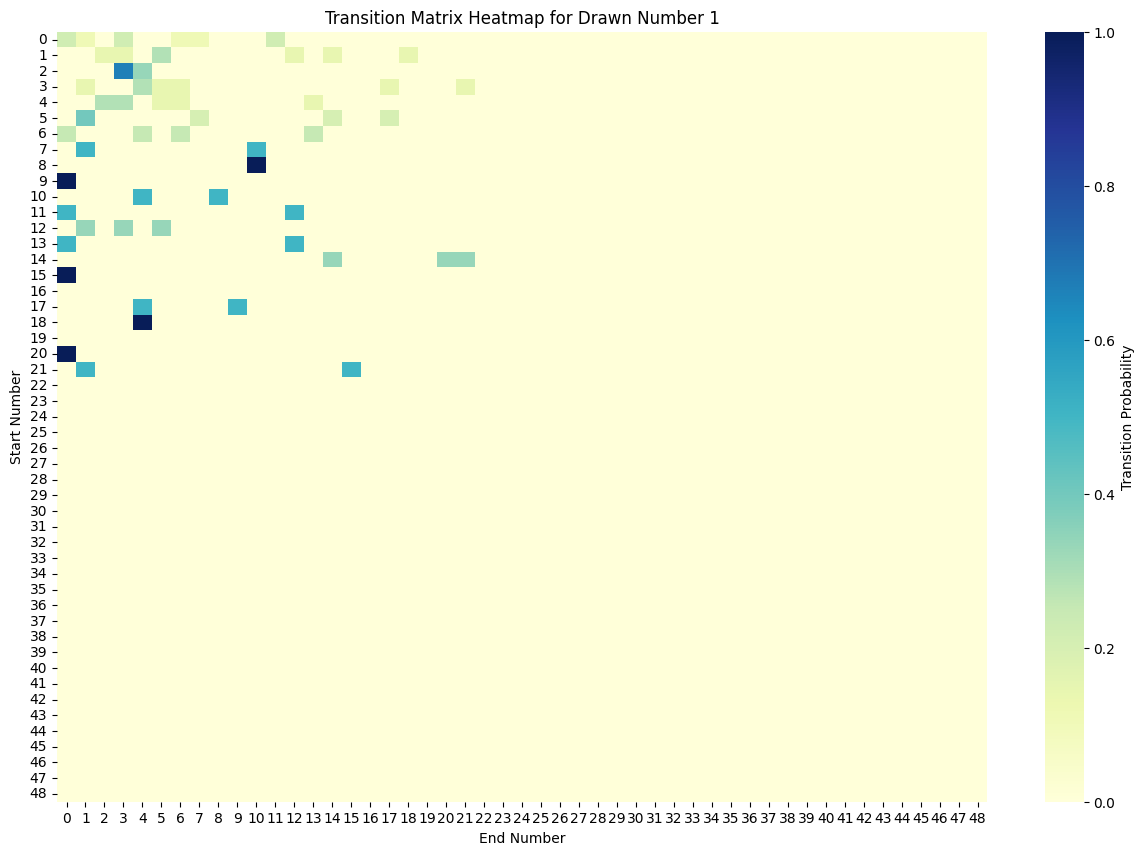

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you've already constructed the transition_matrix as shown previously

plt.figure(figsize=(15, 10))
sns.heatmap(transition_matrix, cmap="YlGnBu", cbar_kws={'label': 'Transition Probability'})
plt.title("Transition Matrix Heatmap for Drawn Number 1")
plt.xlabel("End Number")
plt.ylabel("Start Number")
plt.show()


In [16]:
!pip install pgmpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.5 MB/s eta 0:00:00


In [18]:
model = BayesianModel([('Drawn Number 1', 'Drawn Number 2'),
                       ('Drawn Number 2', 'Drawn Number 3'),
                       ('Drawn Number 3', 'Drawn Number 4'),
                       # ... continue specifying the relationships
                      ])


In [24]:
import pandas as pd

url = 'https://raw.githubusercontent.com/WinningHabits/lottery_dataset/main/lottery-toto_upto_08.23_revised_1.xlsx'
data = pd.read_excel(url)

In [30]:
draw_columns = data.columns[1:-1]
flattened_data = data[draw_columns].values.flatten()


In [32]:
def create_transition_matrix_2nd_order(flattened_data):
    transitions = {}
    total_transitions = 0

    for i in range(len(flattened_data) - 2):
        prev_nums = (flattened_data[i], flattened_data[i+1])
        next_num = flattened_data[i+2]

        if prev_nums not in transitions:
            transitions[prev_nums] = {}
        if next_num not in transitions[prev_nums]:
            transitions[prev_nums][next_num] = 0

        transitions[prev_nums][next_num] += 1
        total_transitions += 1

    # Convert counts to probabilities
    for prev_nums, counts in transitions.items():
        total_counts = sum(counts.values())
        for next_num, count in counts.items():
            transitions[prev_nums][next_num] = count / total_counts

    return transitions, total_transitions

transitions_2nd_order, total_transitions_2nd = create_transition_matrix_2nd_order(flattened_data)


In [33]:
from scipy.sparse import dok_matrix, csr_matrix

# Initialize a sparse matrix for transitions
max_numbers = max(flattened_data)
transition_matrix = dok_matrix((max_numbers * max_numbers, max_numbers * max_numbers))

# Populate the transition matrix
for (prev1, prev2), next_nums in transitions_2nd_order.items():
    row_idx = (prev1 - 1) * max_numbers + (prev2 - 1)
    for next_num, prob in next_nums.items():
        for next_next_num in range(1, max_numbers + 1):
            col_idx = (next_num - 1) * max_numbers + (next_next_num - 1)
            transition_matrix[row_idx, col_idx] = prob * (transitions_2nd_order.get((next_num, next_next_num), {}).get(next_next_num, 0))

# Convert to CSR format for efficient matrix multiplication
transition_matrix = csr_matrix(transition_matrix)


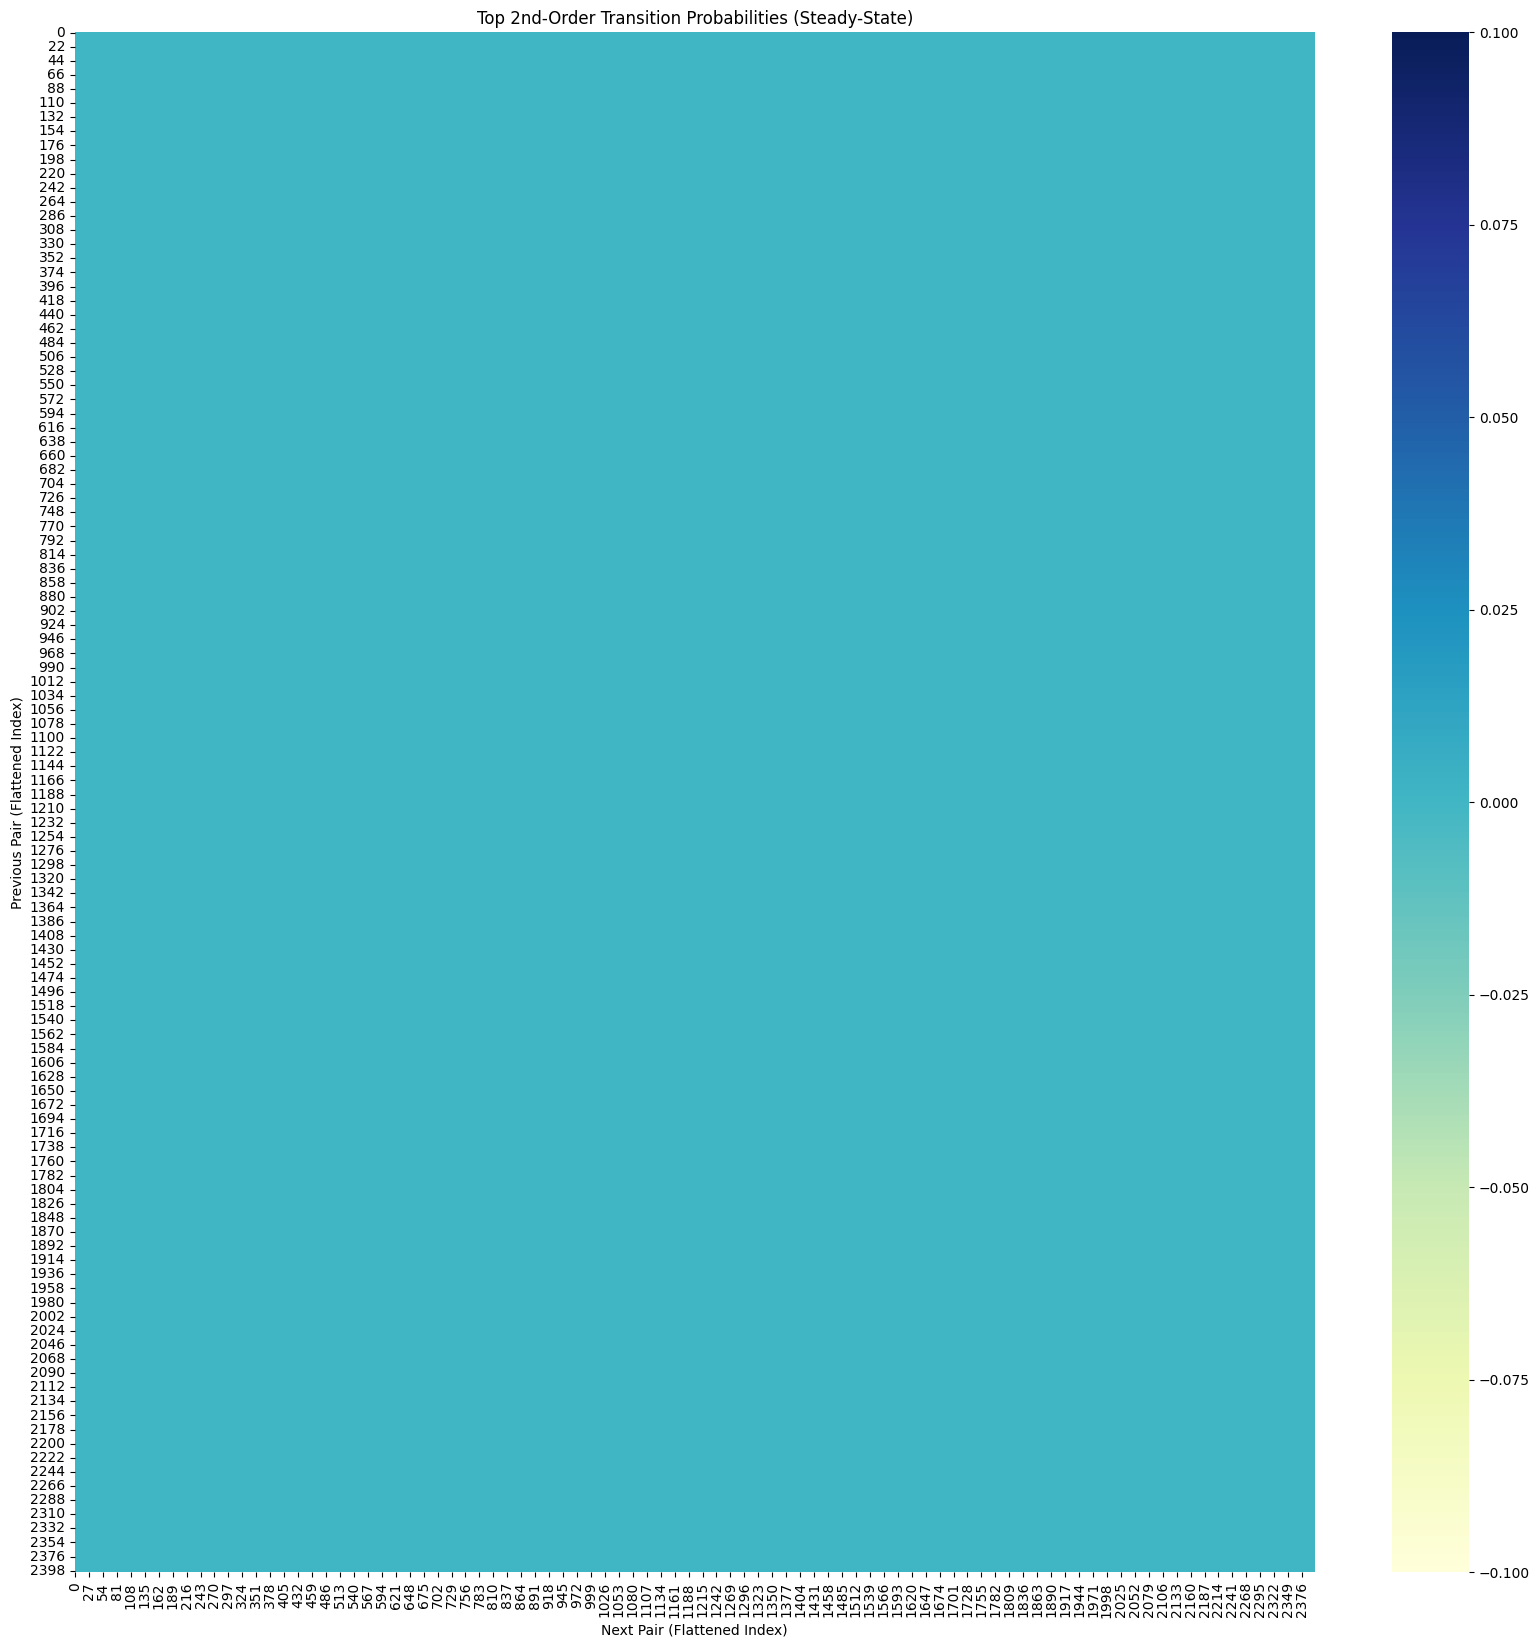

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Taking powers of the matrix to observe convergence
matrix_power = transition_matrix
previous_row_sums = None
converged = False
iterations = 0
max_iterations = 50  # Limit to avoid infinite loops

while not converged and iterations < max_iterations:
    matrix_power = matrix_power @ transition_matrix
    row_sums = matrix_power.sum(axis=1)

    # Check convergence by seeing if row sums remain constant
    if previous_row_sums is not None and np.allclose(previous_row_sums, row_sums, atol=1e-4):
        converged = True
    previous_row_sums = row_sums
    iterations += 1

# Visualize the top transitions using a heatmap
num_top_transitions = 50
top_indices = np.argsort(matrix_power.data)[-num_top_transitions:]
top_transitions = matrix_power.data[top_indices]

heatmap_data = np.zeros((max_numbers * max_numbers, max_numbers * max_numbers))
rows, cols = matrix_power.nonzero()
for idx, value in zip(top_indices, top_transitions):
    heatmap_data[rows[idx], cols[idx]] = value

plt.figure(figsize=(20, 20))
sns.heatmap(heatmap_data, cmap="YlGnBu")
plt.title('Top 2nd-Order Transition Probabilities (Steady-State)')
plt.xlabel('Next Pair (Flattened Index)')
plt.ylabel('Previous Pair (Flattened Index)')
plt.show()


In [37]:
pip install pgmpy


In [ ]:
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

# Load the dataset
data_reloaded = pd.read_excel('https://raw.githubusercontent.com/WinningHabits/lottery_dataset/main/lottery-toto_upto_08.23_revised_1.xlsx')

# Define the Bayesian Network structure using actual column names
edges = [('Draw number 1', 'Draw number 1_next'),
         ('Draw number 2', 'Draw number 1_next'),
         ('Draw number 3', 'Draw number 1_next'),
         ('Draw number 4', 'Draw number 1_next'),
         ('Draw number 5', 'Draw number 1_next'),
         ('Draw number 6', 'Draw number 1_next'),
         ('Additional Number', 'Draw number 1_next')]

model = BayesianModel(edges)

# Prepare the data for training by shifting the 'Draw number 1' column
data_reloaded['Draw number 1_next'] = data_reloaded['Draw number 1'].shift(-1)

# Train the model using Maximum Likelihood Estimation
mle = MaximumLikelihoodEstimator(model, data_reloaded)
model.add_cpds(*mle.get_parameters())

# Verify the model
is_valid = model.check_model()


/usr/local/lib/python3.10/dist-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [3]:
edges = [('Draw number 1', 'Draw number 1_next'),
         ('Draw number 2', 'Draw number 1_next'),
         ('Draw number 3', 'Draw number 1_next'),
         ('Draw number 4', 'Draw number 1_next'),
         ('Draw number 5', 'Draw number 1_next'),
         ('Draw number 6', 'Draw number 1_next'),
         ('Additional Number', 'Draw number 1_next')]


In [5]:
import pandas as pd

# Load the dataset
data_reloaded = pd.read_excel('https://raw.githubusercontent.com/WinningHabits/lottery_dataset/main/lottery-toto_upto_08.23_revised_1.xlsx')


In [7]:
data_reloaded['Draw number 1_next'] = data_reloaded['Draw number 1'].shift(-1)


In [9]:
data_reloaded['Draw number 1_next'] = data_reloaded['Draw number 1'].shift(-1)



In [13]:
data_reloaded['Draw number 1_next'] = data_reloaded['Draw number 1'].shift(-1)


In [14]:
from pgmpy.models import BayesianModel

# Define the Bayesian Network structure using the actual column names from your dataset
edges = [
    ('Draw number 1', 'Draw number 1_next'),
    ('Draw number 2', 'Draw number 1_next'),
    ('Draw number 3', 'Draw number 1_next'),
    ('Draw number 4', 'Draw number 1_next'),
    ('Draw number 5', 'Draw number 1_next'),
    ('Draw number 6', 'Draw number 1_next'),
    ('Additional Number', 'Draw number 1_next')
]

model_new = BayesianModel(edges)


/usr/local/lib/python3.10/dist-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [18]:
import pandas as pd

# Load the dataset
data_new = pd.read_excel('https://raw.githubusercontent.com/WinningHabits/lottery_dataset/main/lottery-toto_upto_08.23_revised_1.xlsx')

# Create the 'Draw number 1_next' column by shifting the 'Draw number 1' column (if it's not already present)
if 'Draw number 1_next' not in data_new.columns:
    data_new['Draw number 1_next'] = data_new['Draw number 1'].shift(-1)


In [2]:
from pgmpy.models import BayesianModel

# Define the Bayesian Network structure using the actual column names from your dataset
edges = [
    ('Draw number 1', 'Draw number 1_next'),
    ('Draw number 2', 'Draw number 1_next'),
    ('Draw number 3', 'Draw number 1_next'),
    ('Draw number 4', 'Draw number 1_next'),
    ('Draw number 5', 'Draw number 1_next'),
    ('Draw number 6', 'Draw number 1_next'),
    ('Additional Number', 'Draw number 1_next')
]

model_new = BayesianModel(edges)


/usr/local/lib/python3.10/dist-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


In [5]:
import pandas as pd

# Load the dataset
data_new = pd.read_excel('https://raw.githubusercontent.com/WinningHabits/lottery_dataset/main/lottery-toto_upto_08.23_revised_1.xlsx')


In [8]:
print(data_new.columns)


Index(['Date by Month', 'Draw number 1', 'Draw number 2', 'Draw number 3',
       'Draw number 4', 'Draw number 5', 'Draw number 6', 'Additional Number'],
      dtype='object')


In [ ]:
Index(['Date by Month', 'Draw number 1', 'Draw number 2', 'Draw number 3',
       'Draw number 4', 'Draw number 5', 'Draw number 6', 'Additional Number'],
      dtype='object')

In [9]:
data_new['Draw number 1_next'] = data_new['Draw number 1'].shift(-1)


In [10]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Define the structure using actual column names
model = BayesianModel([('Draw number 1', 'Draw number 1_next')])

# Train the model using data_new
model.fit(data_new, estimator=MaximumLikelihoodEstimator)

# Inference
inference = VariableElimination(model)
predicted_next_number = inference.map_query(variables=['Draw number 1_next'], evidence={'Draw number 1': 7})


/usr/local/lib/python3.10/dist-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [11]:
print(data_new[['Draw number 1', 'Draw number 1_next']].isna().sum())


Draw number 1         0
Draw number 1_next    1
dtype: int64


In [12]:
data_new.dropna(subset=['Draw number 1_next'], inplace=True)


In [14]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Define the structure using actual column names from the dataset
model = BayesianModel([('Draw number 1', 'Draw number 1_next')])  # Adjusted to use actual column names

# Train the model using data_new
model.fit(data_new, estimator=MaximumLikelihoodEstimator)

# Inference
inference = VariableElimination(model)
predicted_next_number = inference.map_query(variables=['Draw number 1_next'], evidence={'Draw number 1': 7})


/usr/local/lib/python3.10/dist-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [15]:
print(predicted_next_number)


{'Draw number 1_next': 1.0}


In [20]:
data_new_numeric = data_new.apply(pd.to_numeric, errors='coerce')
print(data_new_numeric.isna().sum())



Date by Month         65
Draw number 1          0
Draw number 2          0
Draw number 3          0
Draw number 4          0
Draw number 5          0
Draw number 6          0
Additional Number      0
Draw number 1_next     0
dtype: int64


In [21]:
# Exclude the 'Date by Month' column
data_new_numeric = data_new_numeric.drop(columns=['Date by Month'])

# Now compute the posterior_params
numbers = range(1, int(max(data_new_numeric.values.flatten())) + 1)
posterior_params = {}

prior_a = 1  # Hyperparameter for Beta distribution
prior_b = 1  # Hyperparameter for Beta distribution

for num in numbers:
    observed_successes = (data_new_numeric == num).sum().sum()
    observed_failures = data_new_numeric.size - observed_successes

    posterior_a = prior_a + observed_successes
    posterior_b = prior_b + observed_failures
    posterior_params[num] = (posterior_a, posterior_b)

# Print the contents of posterior_params to verify
print(posterior_params)


{1: (20, 502), 2: (16, 506), 3: (12, 510), 4: (18, 504), 5: (20, 502), 6: (18, 504), 7: (14, 508), 8: (10, 512), 9: (6, 516), 10: (11, 511), 11: (11, 511), 12: (11, 511), 13: (12, 510), 14: (9, 513), 15: (17, 505), 16: (11, 511), 17: (6, 516), 18: (10, 512), 19: (7, 515), 20: (11, 511), 21: (14, 508), 22: (15, 507), 23: (7, 515), 24: (8, 514), 25: (12, 510), 26: (10, 512), 27: (8, 514), 28: (14, 508), 29: (10, 512), 30: (17, 505), 31: (12, 510), 32: (13, 509), 33: (7, 515), 34: (16, 506), 35: (7, 515), 36: (10, 512), 37: (14, 508), 38: (9, 513), 39: (11, 511), 40: (11, 511), 41: (10, 512), 42: (10, 512), 43: (7, 515), 44: (11, 511), 45: (13, 509), 46: (10, 512), 47: (6, 516), 48: (13, 509), 49: (14, 508)}


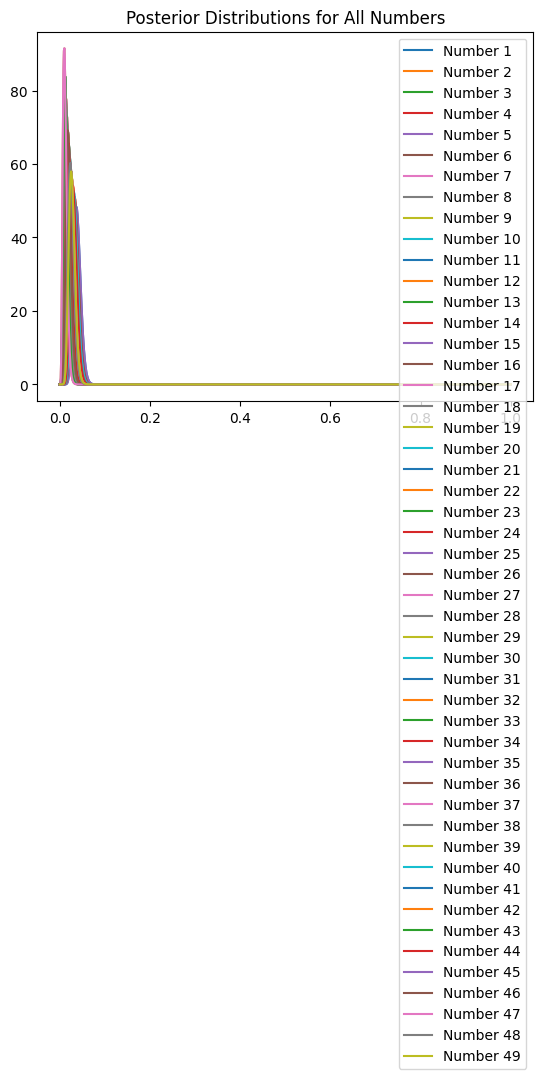

In [22]:
import matplotlib.pyplot as plt
from scipy.stats import beta
import numpy as np

x = np.linspace(0, 1, 1000)

# Visualize Bayesian Inference Results
for num, params in posterior_params.items():
    plt.plot(x, beta(*params).pdf(x), label=f"Number {num}")

plt.title("Posterior Distributions for All Numbers")
plt.legend()
plt.show()


In [27]:
def predict(data_slice):
    return data_slice.mode().iloc[0]


In [29]:
predicted = predict(data_new.iloc[:i])
actual = data_new.iloc[i + 1]


IndexError: ignored

In [31]:
print(len(data_new))
print(data_new.tail())


65
   Date by Month  Draw number 1  Draw number 2  Draw number 3  Draw number 4  \
60      31.07.23              2             23             29             35   
61      04.08.23             19             25             27             28   
62      07.08.23              5             15             18             31   
63      10.08.23              3              6             16             29   
64      14.08.23              5             22             31             32   

    Draw number 5  Draw number 6  Additional Number  Draw number 1_next  
60             39             45                  6                19.0  
61             29             48                 34                 5.0  
62             41             49                 16                 3.0  
63             37             45                 12                 5.0  
64             41             49                 14                 4.0  


In [32]:
for i in range(len(data_new) - 2):
    ...


In [33]:
for i in range(len(data_new) - 2):
    try:
        predicted = predict(data_new.iloc[:i])
        actual = data_new.iloc[i + 1]
        if predicted == actual:
            correct_predictions += 1
    except IndexError:
        print(f"Error at index {i}")
        break


Error at index 0


In [36]:
for i in range(1, len(data_new) - 2):
    try:
        predicted = predict(data_new.iloc[:i])
        actual = data_new.iloc[i + 1]

        if (predicted == actual).all():  # Ensure this line and the next are properly indented
            correct_predictions += 1

    except IndexError:
        print(f"Error at index {i}")
        break


In [38]:
for i in range(1, len(data_new) - 2):
    try:
        predicted = predict(data_new.iloc[:i])
        actual = data_new.iloc[i + 1]

        if (predicted == actual).all():
            correct_predictions += 1

    except IndexError:
        print(f"Error at index {i}")
        break


In [39]:
for i in range(1, len(data_new) - 2):
    try:
        predicted = predict(data_new.iloc[:i])
        actual = data_new.iloc[i + 1]
        if (predicted == actual).all():
            correct_predictions += 1
    except IndexError:
        print(f"Error at index {i}")
        break
